In [1]:
import os
os.chdir("/Coding/Spectrum4Geo/") #Change to ProjectDirectory (One Directory above)

In [2]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms.functional import resize
from dataclasses import dataclass
import os
import numpy as np

from spectrum4geo.dataset.soundingearth_wav2vec2 import Wav2Vec2SoundingEarthDatasetEval, Wav2Vec2SoundingEarthDatasetTrain
from torch.utils.data import DataLoader
from spectrum4geo.transforms import get_transforms_train_sat, get_transforms_train_wave
from spectrum4geo.transforms import get_transforms_val_sat

@dataclass
class Configuration:
    img_size: int = 384                # for satallite images
    model_wav2vec: str = 'facebook/wav2vec2-base-960h'
    sr_kHz = 16
    audio_length_s = 30

    batch_size: int = 4               # keep in mind real_batch_size = 2 * batch_size
    data_folder = "data"               # Dataset
    
    # Augment Images
    prob_rotate: float = 0.75          # rotates the sat image 
    prob_flip: float = 0.5             # flipping the sat image 
    num_workers: int = 0 if os.name == 'nt' else 4 
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu' 
    mean=[1, 1, 1]
    std=[1, 1, 1]
    
config = Configuration()

img_size = config.img_size
img_size_sat = (img_size, img_size)

# Transforms
sat_transforms_train = get_transforms_train_sat(img_size_sat,
                                                    mean=config.mean,
                                                    std=config.std,
                                                    )


wave_transforms_train = get_transforms_train_wave()


train_dataset = Wav2Vec2SoundingEarthDatasetTrain(data_folder=config.data_folder ,
                                          split_csv='train_df.csv',
                                          transforms_sat_image=sat_transforms_train,
                                          transforms_wave=wave_transforms_train,
                                          audio_length_s=config.audio_length_s,
                                          sr_kHz=config.sr_kHz,
                                          processor_wav2vec2=config.model_wav2vec,
                                          prob_flip=config.prob_flip,
                                          prob_rotate=config.prob_rotate,
                                          shuffle_batch_size=config.batch_size,
                                                                                    )

train_dataloader = DataLoader(train_dataset,
                              batch_size=12,  
                              shuffle=True,
                              num_workers=config.num_workers,
                              pin_memory=True,
                              collate_fn=train_dataset.collate_fn)


# Eval
sat_transforms_val = get_transforms_val_sat(img_size_sat,
                                                mean=config.mean,
                                                std=config.std,
                                                )


# Reference Satellite Images
sat_dataset_test = Wav2Vec2SoundingEarthDatasetEval(data_folder=config.data_folder ,
                                    split_csv='test_df.csv',
                                    query_type = "sat",
                                    transforms=sat_transforms_val,
                                    audio_length_s=config.audio_length_s,
                                    sr_kHz=config.sr_kHz,
                                    processor_wav2vec2=config.model_wav2vec,
                                    )

sat_dataloader_test = DataLoader(sat_dataset_test,
                                        batch_size=config.batch_size,
                                        num_workers=config.num_workers,
                                        shuffle=False,
                                        pin_memory=True,
                                        collate_fn=sat_dataset_test.collate_fn)
    
    

# Reference Spectogram Images
wave_dataset_test = Wav2Vec2SoundingEarthDatasetEval(data_folder=config.data_folder ,
                                    split_csv='test_df.csv',
                                    query_type = "audio",
                                    transforms=None,
                                    audio_length_s=config.audio_length_s,
                                    sr_kHz=config.sr_kHz,
                                    processor_wav2vec2=config.model_wav2vec,
                                    )

wave_dataloader_test = DataLoader(wave_dataset_test,
                                    batch_size=config.batch_size,
                                    num_workers=config.num_workers,
                                    shuffle=False,
                                    pin_memory=True,
                                    collate_fn=wave_dataset_test.collate_fn)


print("Reference (Sat) Images Test:", len(sat_dataset_test))
print("Reference (wave) Images Test:", len(wave_dataset_test))
    
dataloader_val_tup = (wave_dataloader_test, sat_dataloader_test)

/home/j0kr0017/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/j0kr0017/conda/lib/python3.12/site-packages/pydantic/main.py:328: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Reference (Sat) Images Test: 10179
Reference (wave) Images Test: 10179


Plotte Train Dataloader Bilder

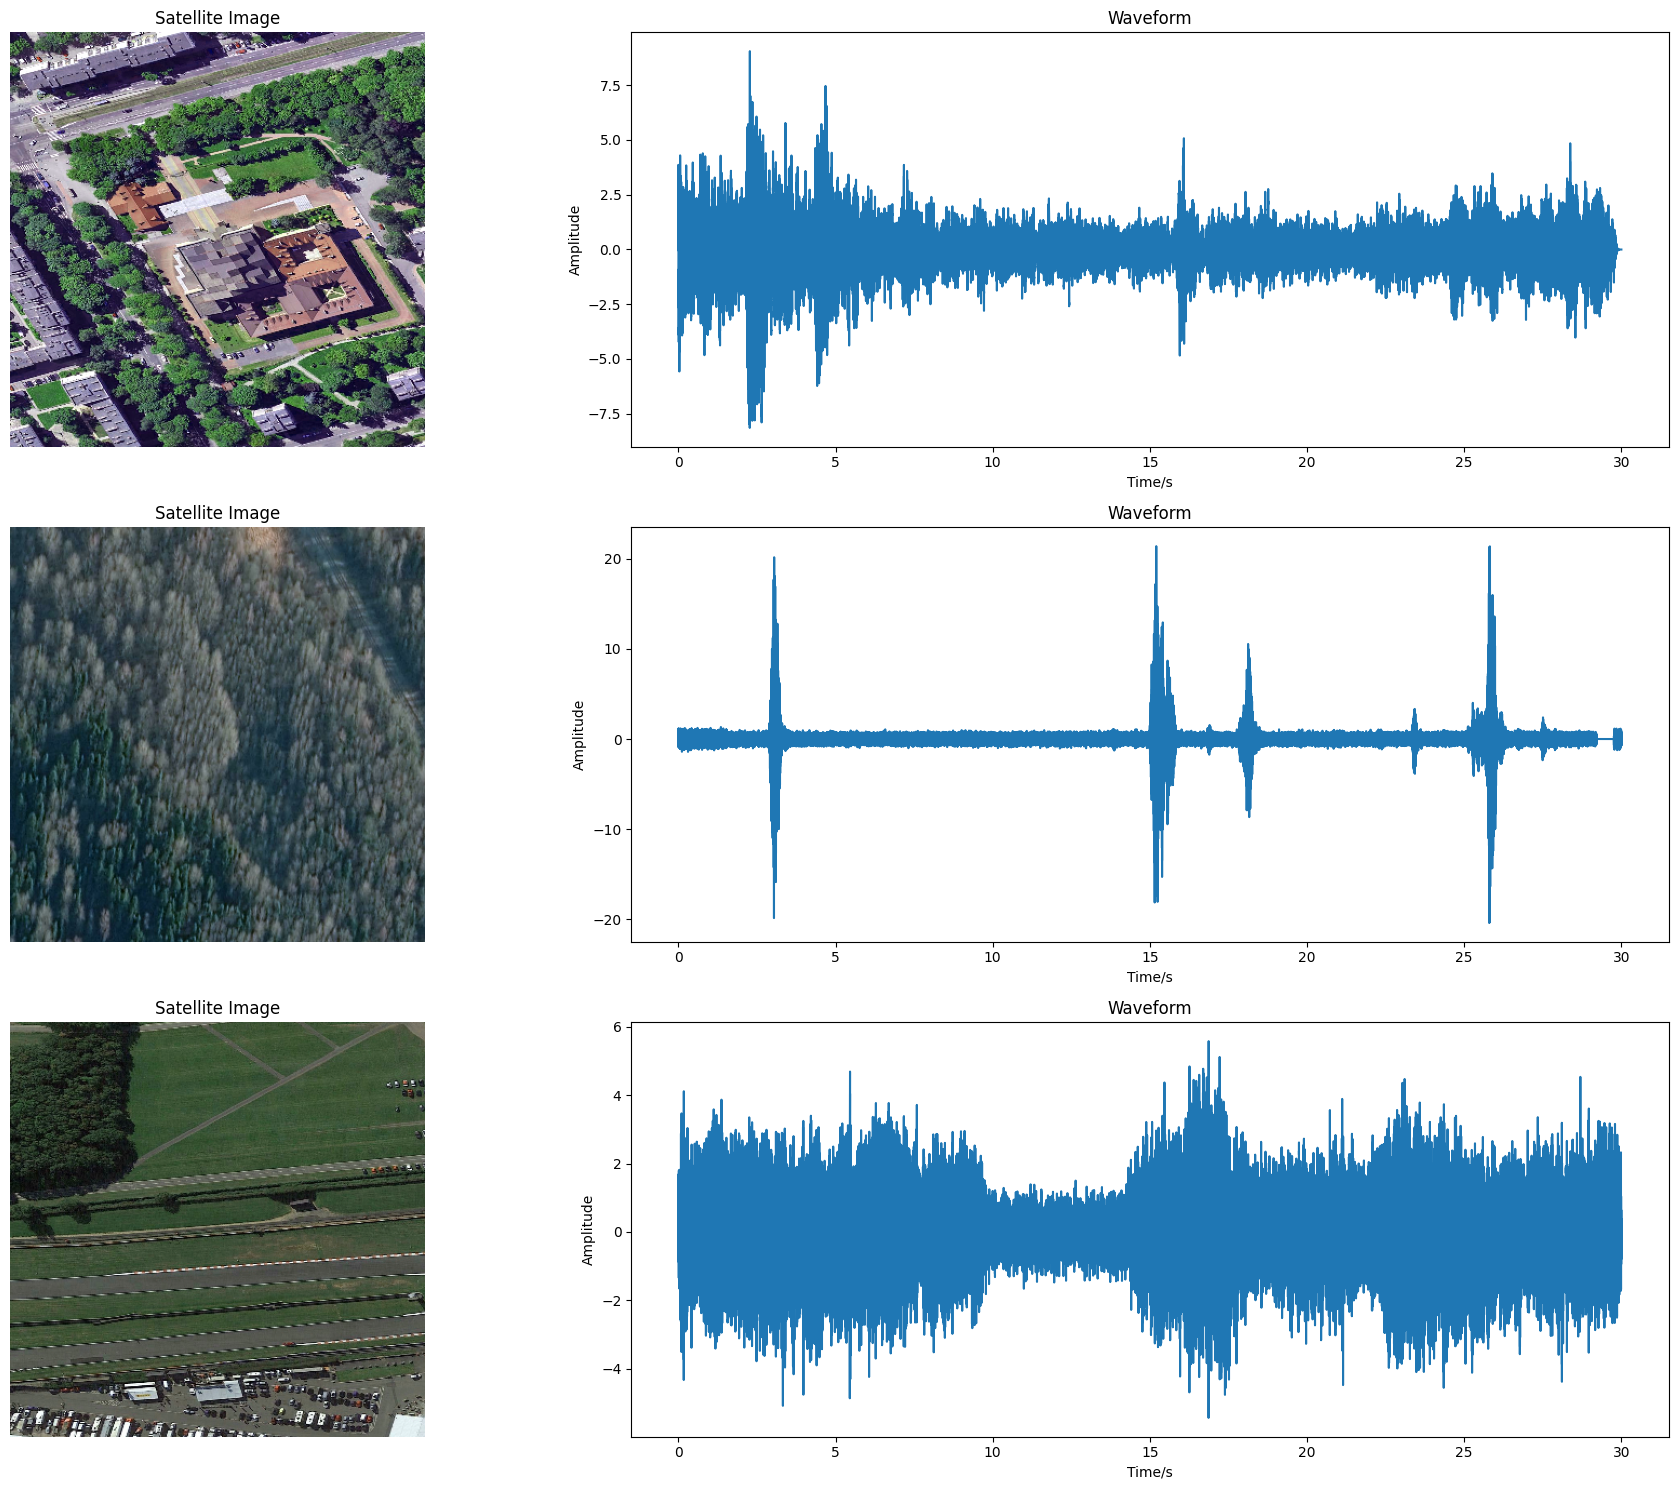

In [3]:
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def plot_images(dataloader, num_images, sat_den_b=True):
    fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(20, 5 * num_images))  
    axs = axs.reshape(-1, 2)  # Ensure correct shape for accessing axs

    image_count = 0
    for i, data in enumerate(dataloader):
        if image_count >= num_images:
            break
        
        sat_images, waves_tensors, _ = data  
        batch_size = sat_images.shape[0]

        for j in range(batch_size):
            if image_count >= num_images:
                break

            sat_image = sat_images[j]
            waves_tensor = waves_tensors[0][j]

            if sat_den_b:
                sat_image = denormalize(sat_image, config.mean, config.std)

            # Plot satellite image
            ax_img = axs[image_count, 0]
            ax_img.imshow(sat_image.permute(1, 2, 0).numpy()) 
            ax_img.axis('off')
            ax_img.set_title('Satellite Image')

            # Plot waveform
            ax_wave = axs[image_count, 1]
            wave_data = waves_tensor.cpu().numpy()
            time_axis = torch.arange(0, len(wave_data)) / (config.sr_kHz * 1e3)
            ax_wave.plot(time_axis, wave_data)
            ax_wave.set_title('Waveform')
            ax_wave.set_xlabel('Time/s')
            ax_wave.set_ylabel('Amplitude')

            image_count += 1

    plt.tight_layout()
    plt.show()

# Example usage
plot_images(train_dataloader, 3, sat_den_b=True)

Plotte Eval Dataloader Bilder

Column: 1, Satellite: 32328, Wave: 32328
Column: 2, Satellite: 49939, Wave: 49939
Column: 3, Satellite: 8484, Wave: 8484


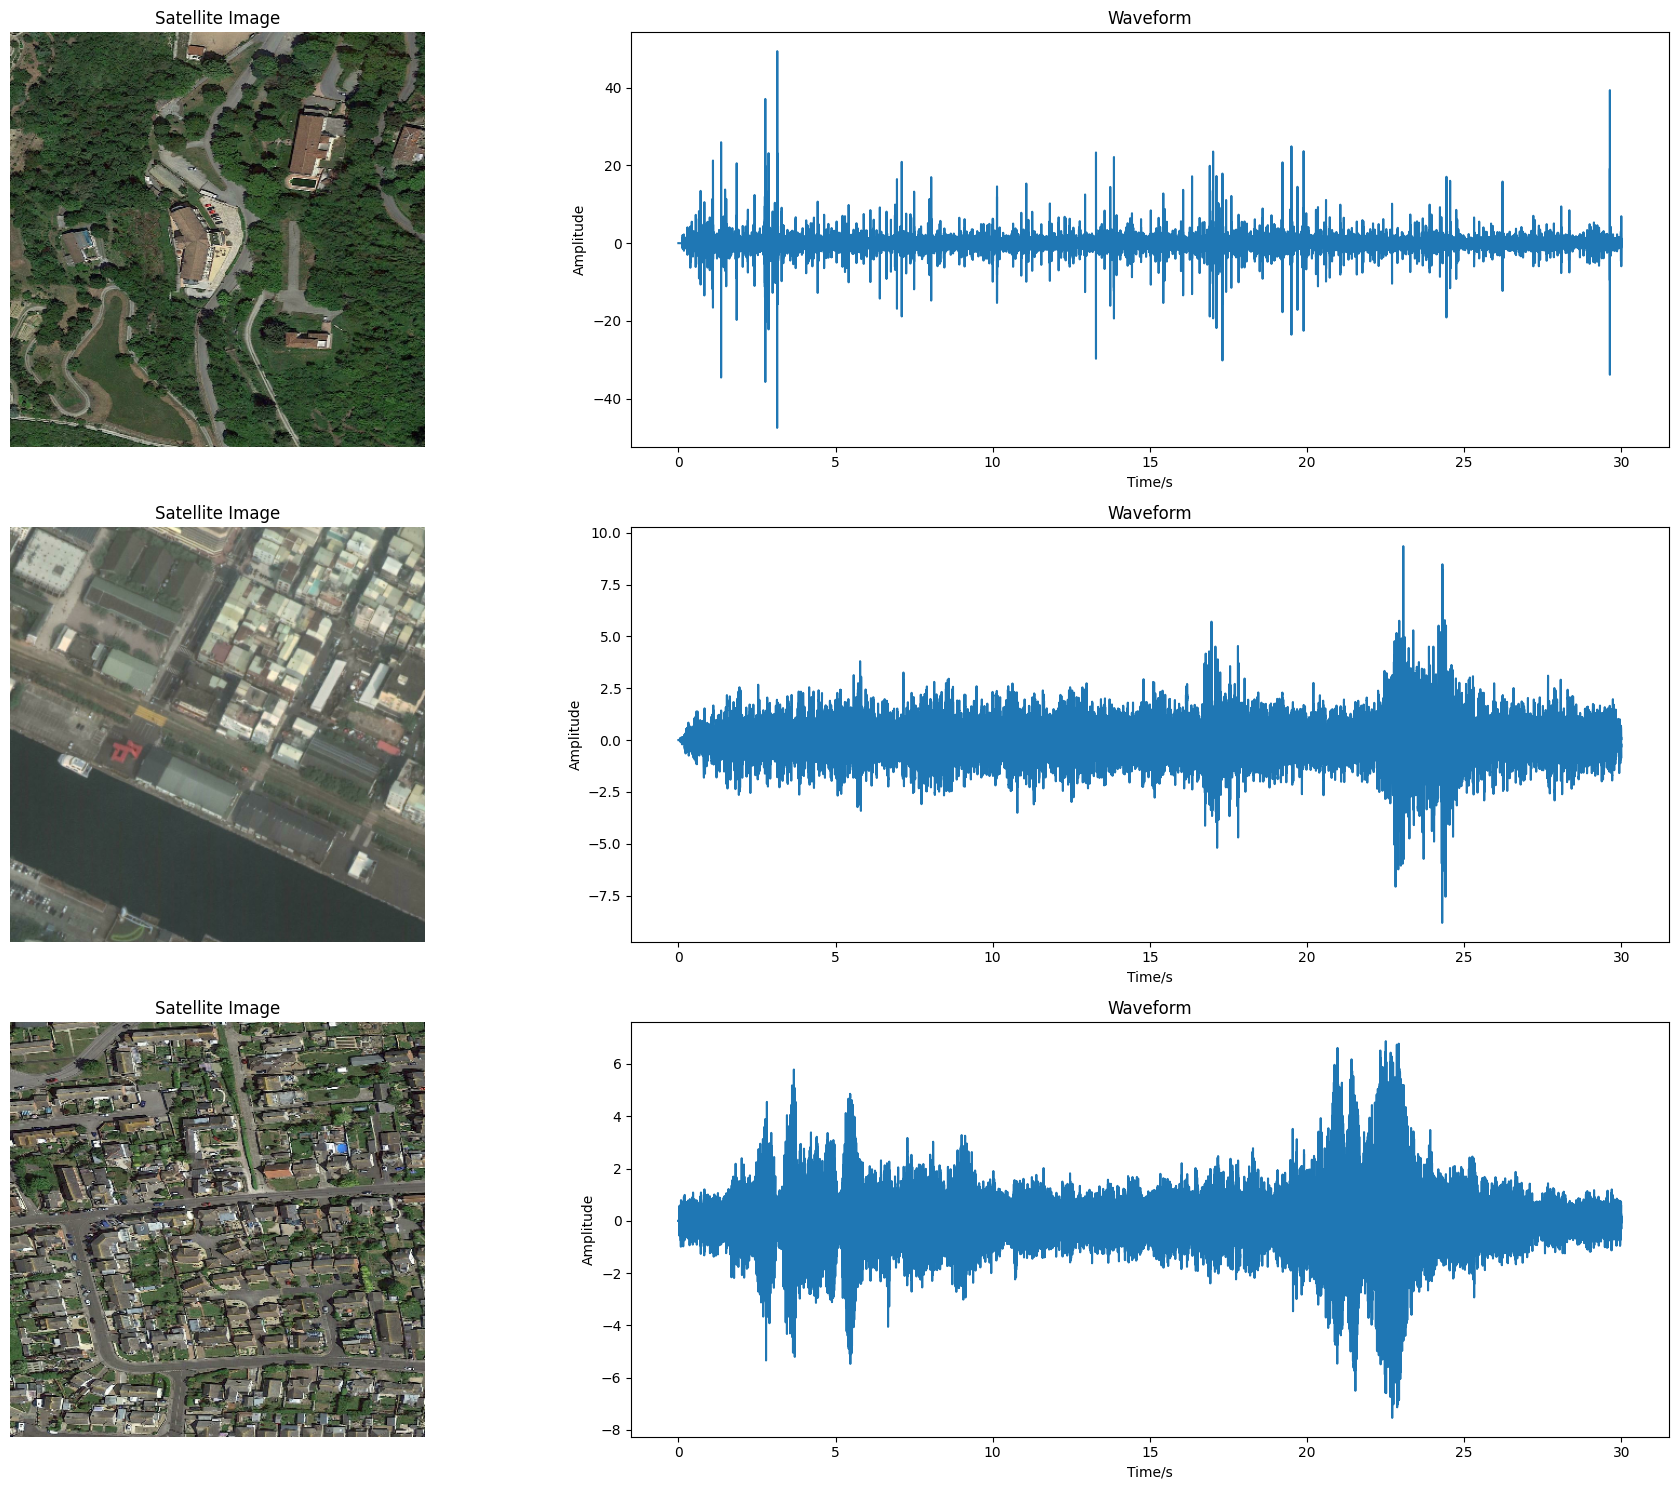

In [4]:
def plot_images_eval(dataloader_tup, num_images, sat_den_b=True):
    fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(20, 5 * num_images))  
    axs = axs.reshape(-1, 2)  # Ensure correct shape for accessing axs
    image_count = 0

    wave_dataloader_test, sat_dataloader_test = dataloader_tup  # Unpack the tuple

    for (wave_images, wave_labels), (sat_images, sat_labels) in zip(wave_dataloader_test, sat_dataloader_test):
        for waves_tensor, sat_image, wave_label, sat_label in zip(wave_images[0], sat_images[0], wave_labels, sat_labels):            

            if image_count >= num_images:
                break

            if sat_den_b:
                sat_image = denormalize(sat_image, config.mean, config.std)

            # Plot satellite image
            ax_img = axs[image_count][0]
            ax_img.imshow(sat_image.permute(1, 2, 0).cpu().numpy()) 
            ax_img.axis('off')
            ax_img.set_title('Satellite Image')

            # Plot waveform
            ax_wave = axs[image_count][1]
            wave_data = waves_tensor.cpu().numpy()
            time_axis = torch.arange(0, len(wave_data)) / (config.sr_kHz * 1e3)
            ax_wave.plot(time_axis, wave_data)
            ax_wave.set_title('Waveform')
            ax_wave.set_xlabel('Time/s')
            ax_wave.set_ylabel('Amplitude')

            image_count += 1
            
            # print labels of the combined image
            print(f'Column: {image_count}, Satellite: {sat_label}, Wave: {wave_label}')

        if image_count >= num_images:
            break

    plt.tight_layout()
    plt.show()

plot_images_eval(dataloader_val_tup, 3,  sat_den_b = True)